<a href="https://colab.research.google.com/github/anitamezzetti/Heston_option_pricing/blob/main/generate_dataset_fixedK_movingS0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install ipynb

In [33]:
import numpy as np
import os
from time import time
import pandas as pd

In [34]:
from ipynb.fs.full.closed_form_solution1 import f, p, p1, p2, call_price

In [35]:
start = time()

# Set the constants
# -----------------------------------------------------------------------------------
r = 0
k = 2
V0 = 0.010
sigma = 0.61
theta = 0.019
kappa = 6.21

T1 = 10

rho = -0.5

In [36]:
S0 = np.arange(1.5,4,0.01)

Stock prices simulation:

In [37]:
def stock_price_generator (t_max, n ,m, r, S0, k, V0, sigma, theta, kappa, rho):
    dt = t_max / n
    
    # Brownian motions:
    dw_v = np.random.normal(size=(m, n)) * np.sqrt(dt)
    dw_i = np.random.normal(size=(m, n)) * np.sqrt(dt)

    dw_s = rho * dw_v + np.sqrt(1.0 - rho ** 2) * dw_i

    # Perform time evolution 
    s = np.empty((m, n + 1)) # initialisation stock prices vector
    s[:, 0] = S0

    v = np.ones(m) * V0

    for t in range(n):
        dv = kappa * (theta - v) * dt + sigma * np.sqrt(v) * dw_v[:, t]
        ds = r * s[:, t] * dt + np.sqrt(v) * s[:, t] * dw_s[:, t]

        v = np.clip(v + dv, a_min=0.0, a_max=None)
        s[:, t + 1] = s[:, t] + ds
      
        
    return s
    

In [38]:
def find_expected_payoff(stock_path, k, r, t_max):
    payoff = max(stock_path[-1] - k, 0) # one payoff for each simulation
    c = payoff * np.exp(-r * t_max)     # in case r=0, this step is useless
    
    return c

In [39]:
time_maturity = 3
num_simulations = 100
n = 100


In [40]:
df = pd.DataFrame(columns=['price', 'stock_zero'])

In [41]:
# fill the dataset
for s0 in S0:
    s = stock_price_generator (time_maturity, n, num_simulations, r, s0, k, V0, sigma, theta, kappa, rho)

    for stock_path in s:
        p = find_expected_payoff(stock_path, k, r, time_maturity)
        
        new_row = {
                      'price':p, 
                      'stock_zero':stock_path[T1],
                  }
        #append row to the dataframe
        df = df.append(new_row, ignore_index=True)


In [47]:
df_round = df.round(1)
df_round_mean = df_round.groupby('stock_zero').mean()
df_round_mean.head()

,price
stock_zero,
1.0,0.000000
1.1,0.000000
1.2,0.000000
1.3,0.001818
1.4,0.006522


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms


In [49]:
closed_price = []
for s0 in S0:
    cp = call_price(kappa, theta, sigma, rho, V0 ,r , time_maturity ,s0, k)
    closed_price.append(cp)

ipynb.fs.full.closed_form_solution1:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


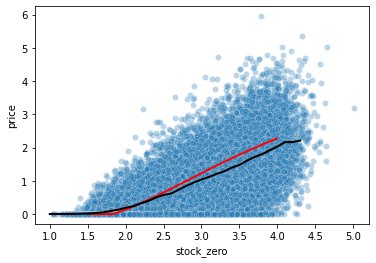

In [54]:
import seaborn as sns
sns.scatterplot(data=df, x="stock_zero", y="price", alpha =0.3)
plt.plot(S0, closed_price, color='r', linewidth=2)
plt.plot(list(df_round_mean.index)[:-5], list(df_round_mean.price)[:-5], color='black', linewidth=2)
plt.show()